## Local DQPT (Trotter error)

In [2]:
from qiskit.quantum_info import Statevector, DensityMatrix,  SparsePauliOp, random_statevector
import itertools as it
from dqpt import *  

from functools import partial
import multiprocessing
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd
import scipy, jax

import matplotlib.pyplot as plt
import numpy as np

from utils import *
from spin_ham import *
from trotter import *
from bounds import *
from dqpt  import *

figs_dir, data_dir = './figs', './data'


## Calculate evolution time with fixed gate number and error tolerance

In [11]:
n = 8
t_max, t_n = 3.0, 100
t_list = np.linspace(0, t_max, t_n)
t_search_list = np.linspace(0.1, 3, 100)
# prefix = 'NNH' # 'Heisenberg'
prefix = 'TFI'

if prefix == 'TFI':
    factor = 2
elif prefix == 'NNH':
    factor = 4

# PBC is important
if prefix == 'TFI':
    H1d = Heisenberg_1d(n, Jx=0.0, Jy=0.0, Jz=0.2, hx=1.0, pbc=False, verbose=False)
    h_list_xyz = [H1d.ham_xyz[0], H1d.ham_xyz[2]]
elif prefix == 'NNH':
    H1d = Heisenberg_1d(n, Jx=0.2, Jy=0.2, Jz=0.2, hx=1.0, pbc=False, verbose=False)
    h_list_xyz = [H1d.ham_xyz[0], H1d.ham_xyz[1], H1d.ham_xyz[2]]
else:
    raise ValueError('Invalid prefix')

H = H1d.ham
# h_list = [H1d.ham_xyz[0], H1d.ham_xyz[1], H1d.ham_xyz[2]]
h_list = H1d.ham_par

print(f'{prefix}: n={n}')
eps = 0.05
gate_lc = 500
k = 3
print('LC Trotter gate: ', gate_lc)
gate_lc_list = [exp_count(r, n, factor, 'LC', k=k) for r in range(50)]
# print('gate_lc_list: ', gate_lc_list)
r_lc_bnd = find_closest_index(gate_lc_list, gate_lc)
lc_error_list = [measure_error(r_lc_bnd, None, t, None, 'lightcone_bound', coeffs=['singl', n, H1d, 0, k-1], verbose=True) for t in t_search_list]
print(list(zip(t_search_list, lc_error_list)))
t_lc_index = find_closest_index(lc_error_list, eps)
t_lc = t_search_list[t_lc_index]
print(f'lightcone time: {t_lc}, lc r: {r_lc_bnd}')

r_st_bnd = int(gate_lc / (1.5*factor*n)) + 1
print('standard Trotter r: ', r_st_bnd)
st_error_list = np.array([measure_error(r_st_bnd, h_list_xyz, t, None, 'worst_loose_bound', coeffs=['singl', n, H1d], verbose=True) for t in t_search_list])
print(list(zip(t_search_list, st_error_list)))

t_st_index = find_closest_index(st_error_list, eps)
t_st = t_search_list[t_st_index]
print(f'lightcone time: {t_lc}; standard Trotter t: {t_st}; error = {st_error_list[t_st_index]}')

TFI: n=8
LC Trotter gate:  500
[(0.1, 2.6692581794622623e-06), (0.1292929292929293, 5.7691908675322134e-06), (0.15858585858585858, 1.0645938565219327e-05), (0.18787878787878787, 1.770206092313998e-05), (0.21717171717171718, 2.7340117591910587e-05), (0.24646464646464647, 3.99626682221475e-05), (0.27575757575757576, 5.597227246446712e-05), (0.305050505050505, 7.577148996948582e-05), (0.33434343434343433, 9.976288038782008e-05), (0.36363636363636365, 0.00012834900337008623), (0.3929292929292929, 0.0001619324185669005), (0.42222222222222217, 0.0002009156856288795), (0.45151515151515154, 0.0002457013642066396), (0.4808080808080808, 0.0002966920139507972), (0.51010101010101, 0.00035429019451196827), (0.5393939393939393, 0.0004188984655407699), (0.5686868686868687, 0.0004909193866878178), (0.597979797979798, 0.0005707555176037288), (0.6272727272727272, 0.000658809417939119), (0.6565656565656565, 0.0007554836473446054), (0.6858585858585858, 0.0008611807654708042), (0.7151515151515151, 0.000976

## Trotter simulation of dynamical quantum phase transition with local Echo

In [8]:
# h_list = [H1d.ham_xyz[0], H1d.ham_xyz[2]]
proj0 = [''.join(i) for i in list(it.product(['I', 'Z'], repeat=n))]
init_state = Statevector.from_label('0'*n)
k = 3
print('local observables: ', generate_proj_pstrs(n, k)[:2**k])
local_ob = SparsePauliOp.from_list([(pstr, 1/2**k) for pstr in generate_proj_pstrs(n, k)[:2**k]]).simplify()

echo_list, echo_pf_list, echo_local_list, echo_local_pf_lc_list, echo_local_pf_st_list = [], [], [], [], []

print('----prepare one step----')
apprx_U_lc_1 = pf_r([h.to_matrix() for h in lc_group(H1d, 0, k-1, 2*n)[:2]], t_lc/r_lc_bnd, 1, order=2)
# apprx_U_lc_1 = pf_r([h.to_matrix() for h in H1d.ham_par], t_lc/r_lc_bnd, 1, order=2)
apprx_U_st_1 = pf_r([h.to_matrix() for h in H1d.ham_xyz], t_st/r_st_bnd, 1, order=2)

for i, t in enumerate(t_list):
    if i % 50 == 0: print(i) 
    else: print('+', end='')
    exact_U = expm(-1j * t * H.to_matrix())
    final_state = exact_U @ init_state.data
    echo = np.abs(init_state.data.conj() @ final_state)**2
    echo_local = final_state.conj() @ local_ob.to_matrix() @ final_state
    # print('echo: ', echo)
    echo_list.append(echo)
    echo_local_list.append(echo_local.real)
    # echo_pf = np.abs(init_state.data.conj() @ final_state_pf_lc)**2
    # echo_pf_list.append(echo_pf)

echo_local_lc_list, echo_local_st_list = [], []
print('\nLC')
for r in range(0, r_lc_bnd+1):
    print('+', end='')
    exact_U_lc = expm(-1j * t_lc/r_lc_bnd * r * H.to_matrix())
    apprx_U_lc = matrix_power(apprx_U_lc_1, r)
    final_state_lc = exact_U_lc @ init_state.data
    final_state_pf_lc = apprx_U_lc @ init_state.data
    echo_local_lc = final_state_lc.conj() @ local_ob.to_matrix() @ final_state_lc
    echo_local_pf_lc = final_state_pf_lc.conj() @ local_ob.to_matrix() @ final_state_pf_lc
    echo_local_pf_lc_list.append(echo_local_pf_lc.real)
    echo_local_lc_list.append(echo_local_lc.real)

print('\nST')
for r in range(0, r_st_bnd+1):
    print('+', end='')
    exact_U_st = expm(-1j * t_st/r_st_bnd * r * H.to_matrix())
    apprx_U_st = matrix_power(apprx_U_st_1, r)
    final_state_st = exact_U_st @ init_state.data
    final_state_pf_st = apprx_U_st @ init_state.data
    echo_local_st = final_state_st.conj() @ local_ob.to_matrix() @ final_state_st
    echo_local_pf_st = final_state_pf_st.conj() @ local_ob.to_matrix() @ final_state_pf_st
    echo_local_pf_st_list.append(echo_local_pf_st.real)
    echo_local_st_list.append(echo_local_st.real)

rate_local_lc_list = [-1/k*np.log(echo) for echo in echo_local_lc_list]
rate_local_st_list = [-1/k*np.log(echo) for echo in echo_local_st_list]

print('\necho_local_list: ', echo_local_list)
print('echo_local_pf_lc_list: ', echo_local_pf_lc_list)
rate_list = [-1/n*np.log(echo) for echo in echo_list]
# rate_pf_list = [-1/n*np.log(echo) for echo in echo_pf_list]
rate_local_list = [-1/k*np.log(echo) for echo in echo_local_list]
rate_local_pf_lc_list = [-1/k*np.log(echo) for echo in echo_local_pf_lc_list]
rate_local_pf_st_list = [-1/k*np.log(echo) for echo in echo_local_pf_st_list]

t_st_list = np.linspace(0, t_st, r_st_bnd+1)
t_lc_list = np.linspace(0, t_lc, r_lc_bnd+1)

t_c = t_list[np.argmax(rate_list)]
t_c_appro = t_list[np.argmax(rate_local_list)]
dqpt_data = {'t':t_list, 'echo':echo_list, 'echo_local':echo_local_list, 'echo_local_pf_lc':echo_local_pf_lc_list, 'echo_local_pf_st':echo_local_pf_st_list, 'rate':rate_list, 'rate_local':rate_local_list, 'rate_local_pf_lc':rate_local_pf_lc_list, 'rate_local_pf_st':rate_local_pf_st_list, 't_lc':t_lc, 't_st':t_st, 'r_lc_bnd':r_lc_bnd, 'r_st_bnd':r_st_bnd, 'gate_lc':gate_lc, 't_c':t_c, 't_c_appro':t_c_appro, 't_st_list': t_st_list, 't_lc_list': t_lc_list, 'rate_local_lc':rate_local_lc_list, 'rate_local_st':rate_local_st_list}
# dqpt_data
## save as .npy file
np.save(f'{data_dir}/dqpt_{prefix}_n={n}_eps={eps}_t={t}.npy', dqpt_data)

local observables:  ['IIIIIIII' 'IIZIIIII' 'IZIIIIII' 'IZZIIIII' 'ZIIIIIII' 'ZIZIIIII'
 'ZZIIIIII' 'ZZZIIIII']
----prepare one step----
0
+++++++++++++++++++++++++++++++++++++++++++++++++50
+++++++++++++++++++++++++++++++++++++++++++++++++
LC
++++++++++++++++++++++
ST
++++++++++++++++++++++
echo_local_list:  [1.0, 0.9972486505522098, 0.9890361353168926, 0.9754861220941113, 0.9568016445561122, 0.933260572585187, 0.9052094465388014, 0.8730558446423802, 0.8372594918858111, 0.7983223515267887, 0.7567779656050576, 0.7131803280164528, 0.6680925822253623, 0.6220758354339521, 0.5756783720894797, 0.5294255323919437, 0.48381049662382813, 0.4392861845624623, 0.3962584420621456, 0.3550806453834867, 0.31604980939946825, 0.27940423989327434, 0.24532272427589485, 0.21392521065799452, 0.18527488369888978, 0.15938150829129882, 0.13620588002524442, 0.11566519541148823, 0.09763913571219845, 0.08197644635811083, 0.06850178950724417, 0.05702265024505422, 0.04733608691725594, 0.03923513257066173, 0.03251467

## Plot data

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


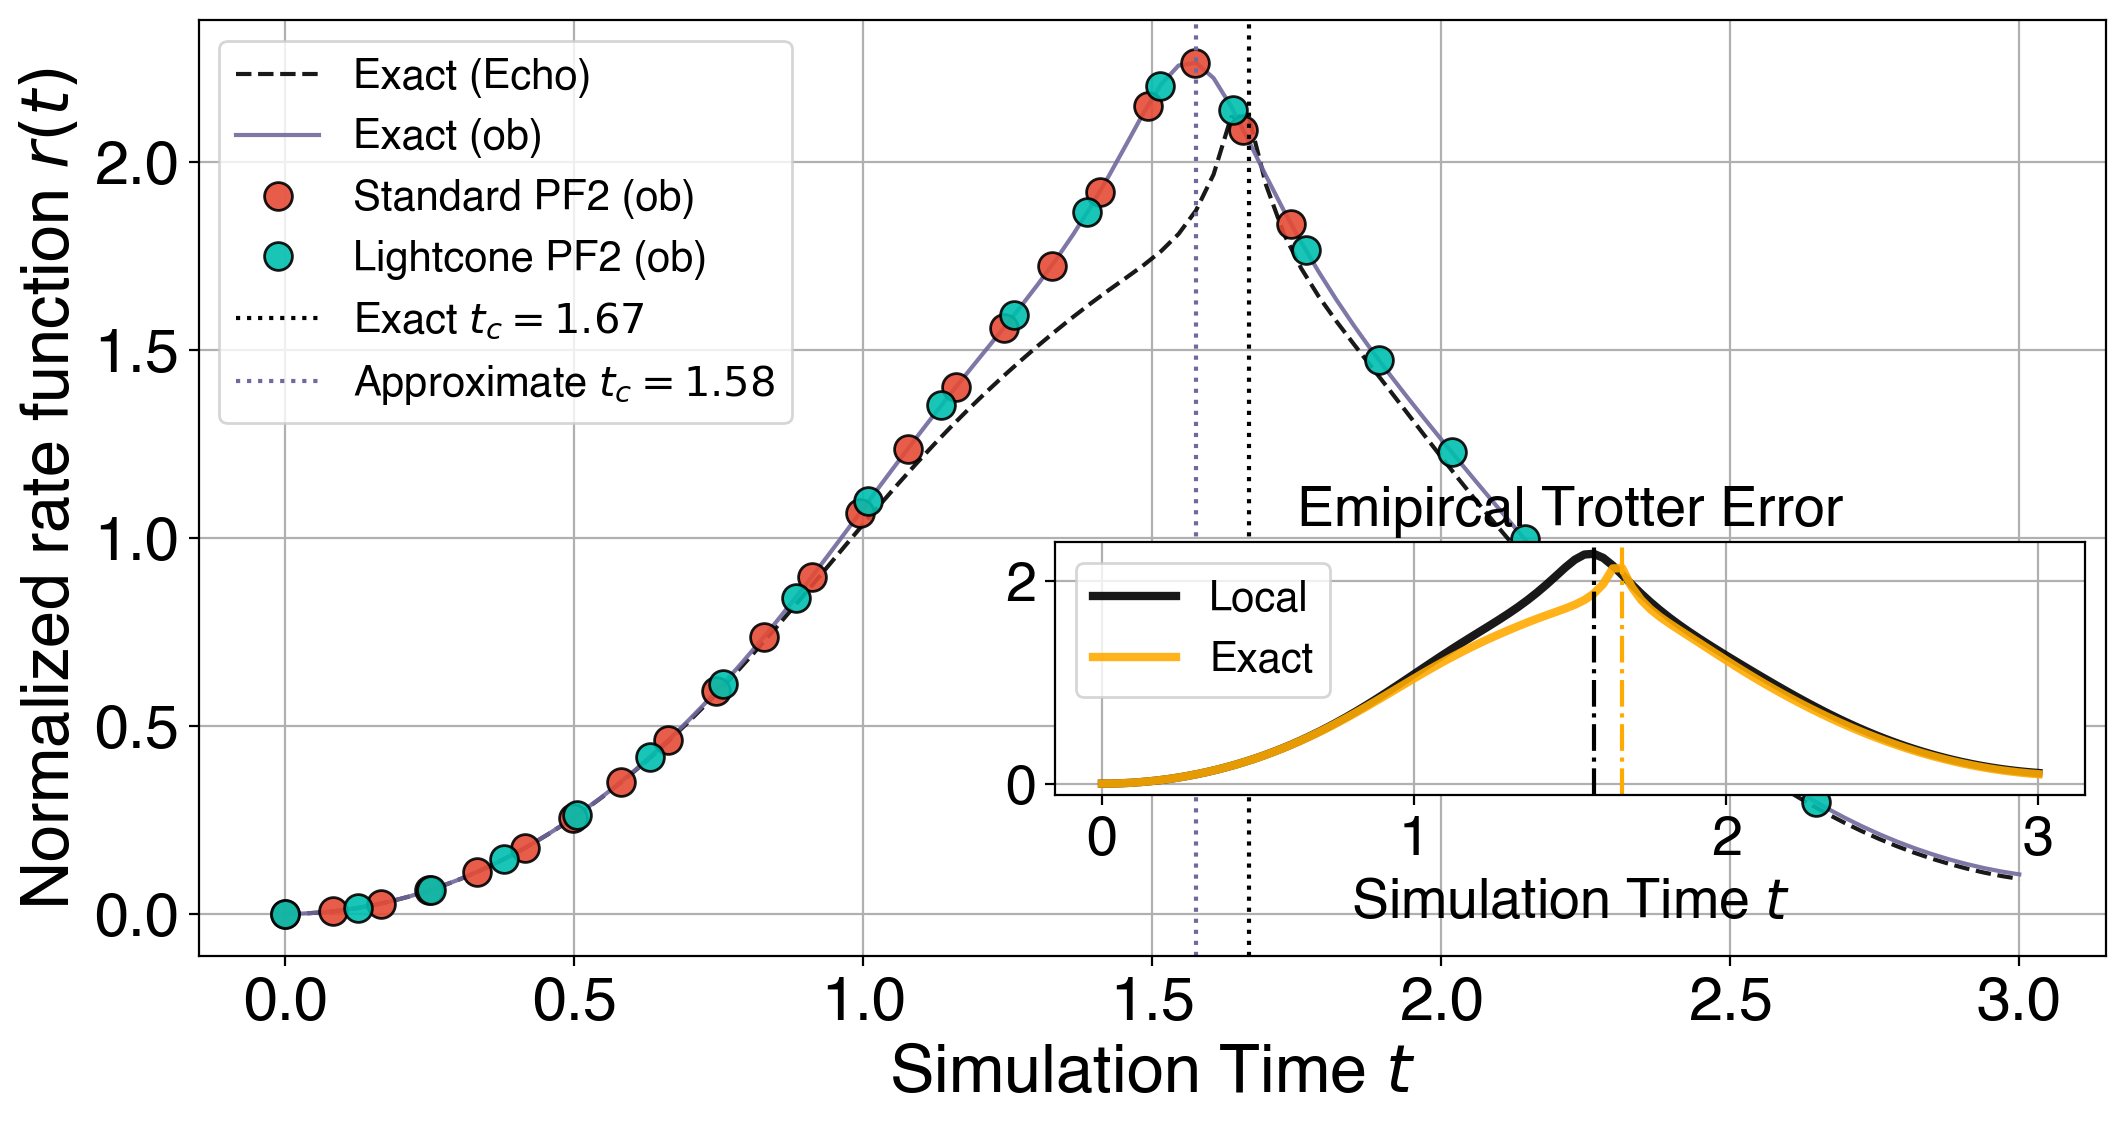

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(11, 6), layout='tight', sharex=True)

# normalizer1, normalizer2 = sum(rate_list[::10]), sum(rate_local_list[::10])
axes.plot(t_list, rate_list, '--', label=rf'Exact (Echo)', c='k')
axes.plot(t_list, rate_local_list, '-', label=rf'Exact (ob)', c='#70699eFF')
# sparse = 4

t_st_index = find_closest_index(t_list, t_st)
axes.plot(t_st_list, rate_local_pf_st_list, 'o', label=rf'Standard PF2 (ob)', markersize=10, c="#E64B35FF")
t_lc_index = find_closest_index(t_list, t_lc)
axes.plot(t_lc_list, rate_local_pf_lc_list, 'o', label=rf'Lightcone PF2 (ob)', markersize=10, c="#00BFAEFF")
axes.grid()

axes.axvline(t_c, ls=':', color='k', label=f'Exact $t_c = {t_c:.2f}$')
axes.axvline(t_c_appro, ls=':', color='k', label=f'Approximate $t_c = {t_c_appro:.2f}$', c='#70699eFF')

axes.legend(loc='upper left'); axes.set_xlabel('Simulation Time $t$'); axes.set_ylabel('Normalized rate function $r(t)$')

axes2 = inset_axes(axes, width="60%", height="30%", loc='lower right',  bbox_to_anchor=(0.1, 0.15, 0.9, 0.9), bbox_transform=axes.transAxes)

## inset of axes[1]
# axes2.stem(t_st_list, abs(np.array(echo_local_st_list)-np.array(echo_local_pf_st_list)), '.', label=rf'ST', markerfmt='C0o', linefmt='C0-', basefmt='C4-')
# axes2.stem(t_lc_list, abs(np.array(echo_local_lc_list)-np.array(echo_local_pf_lc_list)), '.', label=rf'LC', markerfmt='C2o', linefmt='C2-', basefmt='C4-')
axes2.plot(t_list, np.array(dqpt_data['rate_local']), '-', label=rf'Local', c='k', linewidth=3)
axes2.plot(t_list, dqpt_data['rate'], '-', label=rf'Exact', c="#FFAA00FF", linewidth=3)
t_c = t_list[np.argmax(dqpt_data['rate'])]
t_c_appro = t_list[np.argmax(dqpt_data['rate_local'])]
axes2.legend(loc='upper left'); 
axes2.axvline(t_c, ls='-.', label=f'Exact $t_c = {t_c:.2f}$', c="#FFAA00FF")
axes2.axvline(t_c_appro, ls='-.', label=f'Approximate $t_c = {t_c_appro:.2f}$', c='k')
axes2.set_xlabel('Simulation Time $t$'); 

# axes2.set_yticks([0.0000, 0.0001, 0.0002])
axes2.tick_params(axis='y', labelsize=MEDIUM_SIZE+5)
axes2.tick_params(axis='x', labelsize=MEDIUM_SIZE+5)

axes2.set_title('Emipircal Trotter Error', fontsize=MEDIUM_SIZE+5); 
axes2.set_xlabel('Simulation Time $t$', fontsize=MEDIUM_SIZE+5)
axes2.grid()